# Notebook 01: Ensemble Diagnostics

### Set up notebook

In [1]:
# import packages

import xarray as xr
import matplotlib
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pickle

#magic for plots to show up below cells
%matplotlib inline

In [2]:
# Set paths
user = 'mollyw'
user_path = '/glade/scratch/' + user + '/'
work_path = '/glade/work/' + user + '/DA_analysis'

### Load data

Collect parameter perturbations.

In [3]:
 # for base
rsnw = [1.61738,   -1.61783,  -0.173597, -0.926048,  0.0924534,
        -0.994276, -1.56353,  -1.04733,  0.534494,   1.60323,
        -1.33088,  1.71806,   1.65238,   0.368211,   0.0684825,
        1.09968,   -0.333187, 1.3518,    0.872049,   -1.22198,
        1.37112,   -1.41089,  -1.88928,  -1.83958,   1.92808,   
        0.330595,  -1.9124,   0.484801,  -0.334864,  -1.48971
       ]

Cf   = [45.2172,   4.77717,   22.83,     13.4244,    26.1557,
        12.5715,   5.45581,   11.9083,   31.6812,    45.0404,
        8.36396,   46.4757,   45.6548,   26.6026,    25.856,
        38.746,    20.8352,   41.8975,   35.9006,    9.72523,
        42.139,    7.36385,   1.38402,   2.0052,     49.101,
        29.1324,   1.09503,   31.06,     20.8142,    6.37866
       ]

da_rsnw = xr.DataArray(data=rsnw,
                       dims=["ens_member"]
                      ) 
da_Cf = xr.DataArray(data=Cf,
                     dims=["ens_member"]
                    ) 

# for systemic
sys_rsnw = [0.00651056,1.50873,  0.977591,  0.858874,   -1.03231,
         1.46403,  1.89695,   -0.858902, -1.76438,   0.624608,
         1.9911,   0.321581,  -0.0615868,1.61256,    0.557324,  
         -1.68806, 0.552662,  0.608763,  -1.57227,   -0.327516,  
         -1.50227, -1.48203,  1.74815,   -1.27199,   -1.75615,  
         1.4663,   0.469806,  -1.36414,  0.9161,     -1.80777 
        ]

sys_Cf  = [13.6473,  41.4049,   17.8136,   35.5092,    5.54023,
         3.65637,  12.8401,   7.22568,   40.0188,    49.5996,
         18.8372,  36.2645,   30.596,    13.1187,    35.3589,
         7.53087,  34.0493,   27.3954,   21.9173,    24.752,
         13.8429,  21.8972,   37.3771,   23.6201,    0.278207,
         45.7051,  32.2891,   46.5999,   11.7645,    3.26316
        ]

da_sys_rsnw = xr.DataArray(data=sys_rsnw,
                       dims=["ens_member"]
                      ) 
da_sys_Cf = xr.DataArray(data=sys_Cf,
                     dims=["ens_member"])


# for all cases
ksno  = [0.3402,  0.2041,  0.2226,  0.4075,  0.3603,  0.2273,
         0.4739,  0.3755,  0.4178,  0.4271,  0.3134,  0.2723,
         0.2615,  0.3754,  0.2824,  0.3622,  0.4635,  0.4271,
         0.2141,  0.2806,  0.2067,  0.3494,  0.3429,  0.4494, 
         0.2923,  0.4449,  0.4904,  0.2265,  0.4375,  0.377
        ]

vonkar= [0.32418189, 0.29932052, 0.3587505, 0.1710959,  0.51009815,
         0.1856642,  0.40614209, 0.42846386,0.6355926,  0.34846083,
         0.81076184, 0.30550044, 0.61327232,0.47201631, 0.3562774,
         0.25239618, 0.52773335, 0.34315737,0.16612094, 0.27588069,
         0.40051422, 0.20620692, 0.25971456,0.23899935, 0.58294925,
         0.40186158, 0.5192646,  0.17859749,0.35907305, 0.4679701
        ]

dragio= [0.003304,   0.028024,   0.016183,  0.004658,   0.003092,
         0.012415,   0.001987,   0.038776,  0.008962,   0.024295,
         0.008164,   0.101342,   0.013243,  0.042790,   0.007809,
         0.006281,   0.004016,   0.012437,  0.019760,   0.065019,
         0.060824,   0.007411,   0.147175,  0.017802,   0.017751,
         0.005630,   0.011085,   0.020220,  0.073291,   0.048443
        ]
                         
da_ksno = xr.DataArray(data=ksno,
                       dims=["ens_member"]
                      ) 
da_vonkar = xr.DataArray(data=vonkar,
                     dims=["ens_member"])

da_dragio = xr.DataArray(data=dragio,
                       dims=["ens_member"])


Aggregate hemispheric area and volume data, and assign parameters by ensemble member.

In [13]:
cases = ['free30','free30_interaction','free30_systemic'] #,'free30_vonkar','free30_vkCfrsnw', 'free30_dragksno'] 
hemis = ['nh', 'sh']
ens = ['01','02','03','04','05','06','07','08','09','10',
       '11','12','13','14','15','16','17','18','19','20',
       '21','22','23','24','25','26','27','28','29','30'
      ]
ensembles={}

for case in cases:
    da_vol_list = []
    da_area_list = []
    for x in ens:
        eq_vols_file = '/icevol_dnh' + '_' + case + '_ens00{00}'.format(x) + '.txt'
        eq_area_file = '/icearea_dnh' + '_' + case + '_ens00{00}'.format(x) + '.txt'
        # make each file an array
        vol_data = np.loadtxt(work_path + '/volumes/' + case + eq_vols_file)
        area_data = np.loadtxt(work_path + '/areas/' + case + eq_area_file)

        vol_data = vol_data[365:365+365]
        area_data = area_data[365:365+365]
        
        time = np.arange(1,len(vol_data)+1)
        da_v = xr.DataArray(data=vol_data,
                          dims=["time"],
                          coords=dict(time=time),
                          attrs=dict(description="Northern hemisphere sea ice volume",
                                     units="m^3")
                         ) 
        
        da_a = xr.DataArray(data=area_data,
                          dims=["time"],
                          coords=dict(time=time),
                          attrs=dict(description="Northern hemisphere sea ice area",
                                     units="m^2")
                         ) 
        da_vol_list.append(da_v)
        da_area_list.append(da_a)
        
    # add in ensemble means 
    mean_vols_file = '/icevol_dnh' + '_' + case + '_ensmean.txt'
    mean_area_file = '/icearea_dnh' + '_' + case + '_ensmean.txt'
    vol_temp = np.loadtxt(work_path + '/volumes/' + case + mean_vols_file)
    area_temp = np.loadtxt(work_path + '/areas/' + case + mean_area_file)
    
    vol_temp = vol_temp[365:365+365]
    area_temp = area_temp[365:365+365]
    
    if case =='free30':
        ensembles[case] = xr.Dataset(data_vars=dict(volumes=(["ens_member","time"], xr.concat(da_vol_list, dim = 'ens_member')),
                                                    areas = (["ens_member","time"], xr.concat(da_area_list, dim = 'ens_member')),
                                                    rsnw = (["ens_member"], da_rsnw),
                                                    Cf   = (["ens_member"], da_Cf),
                                                    mean_vol = (["time"], vol_temp),
                                                    mean_area = (["time"],area_temp*1000)
                                                   ),
                                     coords=dict(time=time),
                                     attrs=dict(description="ensemble northern hemispheric aggregate quantities")
                                    )
    elif case =='free30_systemic':
        ensembles[case] = xr.Dataset(data_vars=dict(volumes=(["ens_member","time"], xr.concat(da_vol_list, dim = 'ens_member')),
                                                    areas = (["ens_member","time"], xr.concat(da_area_list, dim = 'ens_member')),
                                                    rsnw = (["ens_member"], da_sys_rsnw),
                                                    Cf   = (["ens_member"], da_sys_Cf),
                                                    ksno = (["ens_member"], da_ksno),
                                                    mean_vol = (["time"], vol_temp),
                                                    mean_area = (["time"],area_temp*1000)
                                                   ),
                                     coords=dict(time=time),
                                     attrs=dict(description="ensemble northern hemispheric aggregate quantities")
                                    )
    elif case == 'free30_interaction':
        ensembles[case] = xr.Dataset(data_vars=dict(volumes=(["ens_member","time"], xr.concat(da_vol_list, dim = 'ens_member')),
                                                    areas = (["ens_member","time"], xr.concat(da_area_list, dim = 'ens_member')),
                                                    vonkar = (["ens_member"], da_vonkar),
                                                    dragio   = (["ens_member"], da_dragio),
                                                    mean_vol = (["time"], vol_temp),
                                                    mean_area = (["time"],area_temp*1000)
                                                   ),
                                     coords=dict(time=time),
                                     attrs=dict(description="ensemble northern hemispheric aggregate quantities")
                                    )
                    

Collect timeseries means (spatial info) for all ensembles. Pickle the ensembles bc this takes hella long to run.

In [5]:
# cases = ['free30','free30_interaction','free30_systemic']
# ds_list = []
# for case in cases:
#     files = sorted(glob.glob('/glade/scratch/mollyw/archive/'+case+'/ice/hist/'+case+'.cice.h.2016-*[0-9]*-*[0-9]*.nc'))
    
#     ds = xr.open_mfdataset(files, concat_dim='time',parallel=True)
#     ds_list.append(ds)

# ensembles = xr.concat(ds_list, dim='ensemble')

# with open('ensemble.p', 'wb') as fp:
#         pickle.dump(ensembles, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
with open('ensemble.p', 'rb') as fp:
    ensemble_timeseries = pickle.load(fp)

### Examine standard case

Text(0.5, 0.98, 'Annual cycle of ensemble spread')

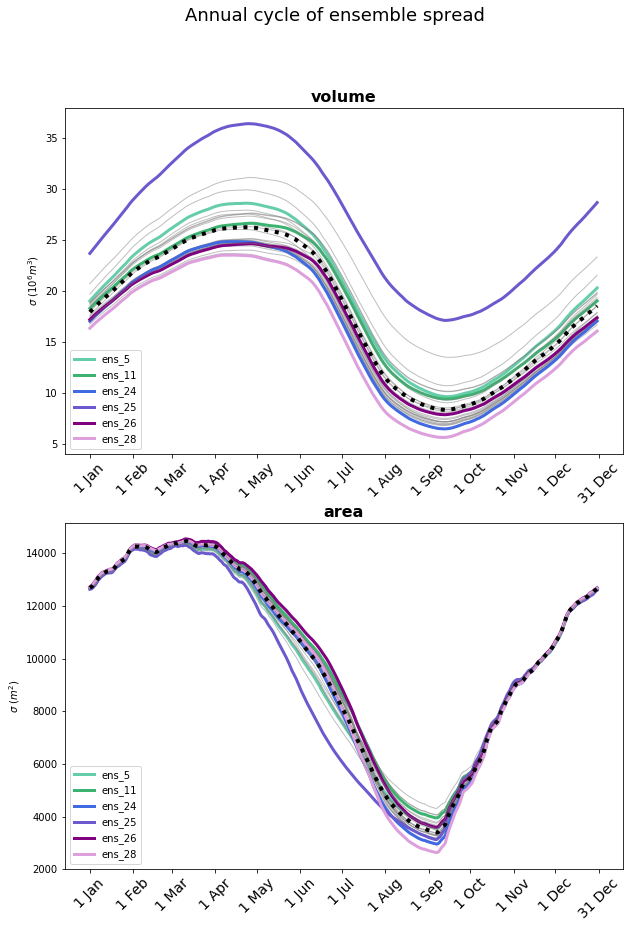

In [33]:
test = 'free30'

fig,axes = plt.subplots(figsize = (10,14));
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
num = np.arange(1,31)

cols = ['mediumaquamarine','mediumseagreen','royalblue','slateblue','purple','plum']
members = [28, 5, 11, 25, 24, 26]
count = 0
for i in num:
    data1 = ensembles[test].sel(ens_member=(i-1)).volumes.values
    data2 = ensembles[test].sel(ens_member=(i-1)).areas.values
    if i in members:
        ax1.plot(data1, linewidth = 3, color = cols[count], label = 'ens_'+str(i))
        ax2.plot(data2, linewidth = 3, color = cols[count], label = 'ens_'+str(i))
        count += 1
    else:
        ax1.plot(data1, linewidth = 1, color = 'grey', alpha = 0.5)
        ax2.plot(data2, linewidth = 1, color = 'grey', alpha = 0.5)

mean1 = ensembles[test].mean_vol.values
mean2 = ensembles[test].mean_area.values
ax1.plot(mean1, linewidth = 4, color = 'black', linestyle='dotted')
ax2.plot(mean2, linewidth = 4, color = 'black', linestyle='dotted')

ax1.set_xticks([0,31,31+28,31+28+31,31+28+31+30,31+28+31+30+31,31+28+31+30+31+30,31+28+31+30+31+30+31,31+28+31+30+31+30+31+31,31+28+31+30+31+30+31+31+30,31+28+31+30+31+30+31+31+30+31,31+28+31+30+31+30+31+31+30+31+30,31+28+31+30+31+30+31+31+30+31+30+31])
ax1.set_xticklabels(['1 Jan','1 Feb','1 Mar','1 Apr','1 May','1 Jun','1 Jul','1 Aug','1 Sep','1 Oct','1 Nov','1 Dec','31 Dec'], rotation=45, fontsize=14)
ax2.set_xticks([0,31,31+28,31+28+31,31+28+31+30,31+28+31+30+31,31+28+31+30+31+30,31+28+31+30+31+30+31,31+28+31+30+31+30+31+31,31+28+31+30+31+30+31+31+30,31+28+31+30+31+30+31+31+30+31,31+28+31+30+31+30+31+31+30+31+30,31+28+31+30+31+30+31+31+30+31+30+31])
ax2.set_xticklabels(['1 Jan','1 Feb','1 Mar','1 Apr','1 May','1 Jun','1 Jul','1 Aug','1 Sep','1 Oct','1 Nov','1 Dec','31 Dec'], rotation = 45, fontsize=14) 
ax1.legend()
ax2.legend()
ax1.set_ylabel('$\sigma$ ($10^6 m^3$)')
ax2.set_ylabel('$\sigma$ ($m^2$)')
ax1.set_title('volume', fontsize=16, fontweight = 'bold')
ax2.set_title('area', fontsize=16, fontweight = 'bold')
plt.suptitle('Annual cycle of ensemble spread', fontsize = 18)

# plt.tight_layout()

In [34]:
trial = ensembles[test]

In [37]:
to_plot

<xarray.DataArray (ens_member: 15, time: 365)>
array([[18.02595, 18.1702 , 18.31796, ..., 18.30221, 18.42755, 18.55213],
       [19.01681, 19.17171, 19.32897, ..., 20.0201 , 20.15607, 20.29151],
       [16.40052, 16.53708, 16.67689, ..., 15.89417, 16.00953, 16.1229 ],
       ...,
       [23.67899, 23.85284, 24.02693, ..., 28.33572, 28.49731, 28.65929],
       [17.19666, 17.32745, 17.46115, ..., 17.15163, 17.26002, 17.36687],
       [16.34465, 16.48002, 16.61832, ..., 15.8404 , 15.95392, 16.06535]])
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
Dimensions without coordinates: ens_member

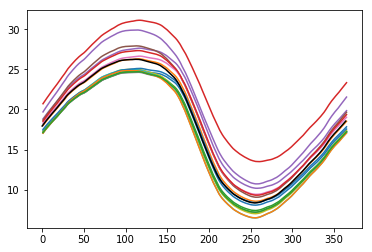

In [57]:
to_plot = trial.volumes.where(trial.rsnw < 0, drop=True)
plt.plot(to_plot.time, to_plot.values.T)
plt.plot(trial.mean_vol, color='black')